In [1]:
import sys
sys.path.append("..")

from predict import perform_inference
from rfw_loader import create_dataloaders
from train import train, save_model

import torch
torch.manual_seed(42)


ImportError: cannot import name 'save_model' from 'train' (/home/rasta/fair compression/fair-neural-compression-eval/src/notebooks/../train.py)

In [2]:
EPOCHS = 5
LEARNING_RATE = 0.01

BATCH_SIZE = 32
DEVICE = 2

In [3]:
device = torch.device(f'cuda:{DEVICE}' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=2)

# Get Train and Validation Loss Curves

In [4]:
import torch
import torchvision.models as models
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F


class MultiHeadResNet(nn.Module):
    def __init__(self, output_dims):
        super(MultiHeadResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))
        self.heads = nn.ModuleDict()
        for head, num_classes in output_dims.items():
            self.heads[head] = nn.Linear(num_features, num_classes)

    def forward(self, x):
        features = self.resnet(x).squeeze()
        outputs = {}
        for head, head_module in self.heads.items():
            output_logits = head_module(features)
            outputs[head] = F.softmax(output_logits, dim=1)
        return outputs

In [5]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

RACE_LABELS = ['Indian', 'Asian', 'African', 'Caucasian']

def train_numerical_rfw(
        model, 
        optimizer,
        num_epochs, 
        lr, 
        train_loader, 
        valid_loader,
        device,
        save_dir,
        model_name,
        patience=5  # Number of epochs to wait for improvement in validation loss before stopping
    ):
    criterion = nn.CrossEntropyLoss()
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer = optimizer(model.parameters(), lr=lr)
    
    train_losses = []
    valid_losses = []
    
    best_valid_loss = float('inf')
    no_improvement_count = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs} - Training") as pbar:
            for inputs, targets, races in train_loader:
                inputs, targets = inputs.to(device).float(), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = 0
                for i, head in enumerate(outputs):
                    loss += criterion(outputs[head], targets[:, i].to(torch.int64))
                loss.backward()
                optimizer.step()
                running_train_loss += loss.item() * inputs.size(0)
                pbar.update(1)
            avg_train_loss = running_train_loss / len(train_loader.dataset)
            pbar.set_postfix(train_loss=avg_train_loss)
        
        print(f'Epoch {epoch + 1} train loss : {avg_train_loss}')
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        running_valid_loss = 0.0
        with torch.no_grad():
            with tqdm(total=len(valid_loader), desc=f"Epoch {epoch+1}/{num_epochs} - Validation") as pbar:
                for inputs, targets, races in valid_loader:
                    inputs, targets = inputs.to(device).float(), targets.to(device)
                    outputs = model(inputs)
                    loss = 0
                    for i, head in enumerate(outputs):
                        loss += criterion(outputs[head], targets[:, i].to(torch.int64))
                    running_valid_loss += loss.item() * inputs.size(0)
                    pbar.update(1)
                avg_valid_loss = running_valid_loss / len(valid_loader.dataset)  # Compute average validation loss
                pbar.set_postfix(valid_loss=avg_valid_loss)
        print(f'Epoch {epoch + 1} valid loss : {avg_valid_loss}')
        valid_losses.append(avg_valid_loss)
        
        # Check for early stopping
        if avg_valid_loss < best_valid_loss:
            print(f'Found better model. Best loss: {avg_valid_loss}')
            best_valid_loss = avg_valid_loss
            no_improvement_count = 0
            print(f'Saving best model to {save_dir}/best_{model_name}.pth')
            torch.save(model, f'{save_dir}/best_{model_name}.pth')
        else:
            no_improvement_count += 1
            if no_improvement_count >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    return model, train_losses, valid_losses

/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warn

Epoch 1 train loss : 5.929486701228805


Epoch 1/30 - Validation: 100%|██████████| 191/191 [00:05<00:00, 36.62it/s, valid_loss=5.91]


Epoch 1 valid loss : 5.905997045755269
Found better model. Best loss: 5.905997045755269
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=1.pth


Epoch 2/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 29.73it/s, train_loss=5.87]


Epoch 2 train loss : 5.871589835784551


Epoch 2/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.06it/s, valid_loss=5.88]


Epoch 2 valid loss : 5.875475353177712
Found better model. Best loss: 5.875475353177712
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=1.pth


Epoch 3/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.35it/s, train_loss=5.85]


Epoch 3 train loss : 5.851686909270562


Epoch 3/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.49it/s, valid_loss=5.86]


Epoch 3 valid loss : 5.8632550802435945
Found better model. Best loss: 5.8632550802435945
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=1.pth


Epoch 4/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.40it/s, train_loss=5.84]


Epoch 4 train loss : 5.837090683224971


Epoch 4/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.70it/s, valid_loss=5.88]


Epoch 4 valid loss : 5.884242773016887


Epoch 5/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 31.28it/s, train_loss=5.82]


Epoch 5 train loss : 5.8201916712356425


Epoch 5/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.51it/s, valid_loss=5.88]


Epoch 5 valid loss : 5.876429348151646


Epoch 6/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 31.25it/s, train_loss=5.81]


Epoch 6 train loss : 5.808100413980868


Epoch 6/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.54it/s, valid_loss=5.87]


Epoch 6 valid loss : 5.870938292005304


Epoch 7/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 31.14it/s, train_loss=5.79]


Epoch 7 train loss : 5.791415677015593


Epoch 7/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 39.22it/s, valid_loss=5.9]


Epoch 7 valid loss : 5.904794296555244


Epoch 8/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.48it/s, train_loss=5.77]


Epoch 8 train loss : 5.769278210651495


Epoch 8/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 40.74it/s, valid_loss=5.88]


Epoch 8 valid loss : 5.877517722193546


Epoch 9/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.87it/s, train_loss=5.75]


Epoch 9 train loss : 5.753158565578144


Epoch 9/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.38it/s, valid_loss=5.94]


Epoch 9 valid loss : 5.943963387078633


Epoch 10/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.37it/s, train_loss=5.73]


Epoch 10 train loss : 5.733828438727445


Epoch 10/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 45.10it/s, valid_loss=5.91]


Epoch 10 valid loss : 5.9112121782911915


Epoch 11/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.99it/s, train_loss=5.71]


Epoch 11 train loss : 5.708923483579353


Epoch 11/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 41.23it/s, valid_loss=5.91]


Epoch 11 valid loss : 5.9149675552450836


Epoch 12/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.56it/s, train_loss=5.69]


Epoch 12 train loss : 5.690739998037702


Epoch 12/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.47it/s, valid_loss=5.91]


Epoch 12 valid loss : 5.909900670293477


Epoch 13/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.53it/s, train_loss=5.66]


Epoch 13 train loss : 5.6616263649948815


Epoch 13/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.62it/s, valid_loss=6.03]


Epoch 13 valid loss : 6.0339462496028355
Early stopping at epoch 13


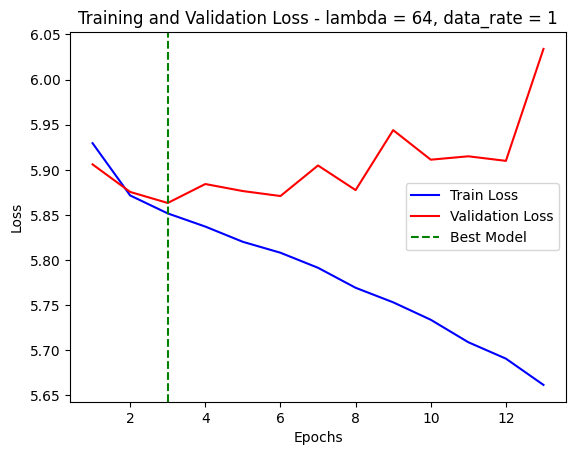

/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warn

Epoch 1 train loss : 5.922943597305602


Epoch 1/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.85it/s, valid_loss=5.86]


Epoch 1 valid loss : 5.863687727099431
Found better model. Best loss: 5.863687727099431
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=3.pth


Epoch 2/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.66it/s, train_loss=5.84]


Epoch 2 train loss : 5.842658582822121


Epoch 2/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.94it/s, valid_loss=5.85]


Epoch 2 valid loss : 5.852473858169608
Found better model. Best loss: 5.852473858169608
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=3.pth


Epoch 3/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.76it/s, train_loss=5.82]


Epoch 3 train loss : 5.815538342757994


Epoch 3/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.33it/s, valid_loss=5.85]


Epoch 3 valid loss : 5.854020759089008


Epoch 4/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.43it/s, train_loss=5.79]


Epoch 4 train loss : 5.793781617645341


Epoch 4/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.22it/s, valid_loss=5.83]


Epoch 4 valid loss : 5.825285914221767
Found better model. Best loss: 5.825285914221767
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=3.pth


Epoch 5/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 29.94it/s, train_loss=5.78]


Epoch 5 train loss : 5.775850380302448


Epoch 5/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.05it/s, valid_loss=5.83]


Epoch 5 valid loss : 5.83223658182648


Epoch 6/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.25it/s, train_loss=5.75]


Epoch 6 train loss : 5.752313921493844


Epoch 6/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.24it/s, valid_loss=5.83]


Epoch 6 valid loss : 5.828188867370124


Epoch 7/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 29.68it/s, train_loss=5.73]


Epoch 7 train loss : 5.732042674443905


Epoch 7/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.52it/s, valid_loss=5.83]


Epoch 7 valid loss : 5.828330819388756


Epoch 8/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.68it/s, train_loss=5.71]


Epoch 8 train loss : 5.71137142677962


Epoch 8/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.37it/s, valid_loss=5.85]


Epoch 8 valid loss : 5.845045654551773


Epoch 9/30 - Training: 100%|██████████| 889/889 [00:30<00:00, 29.54it/s, train_loss=5.68]


Epoch 9 train loss : 5.684938991234197


Epoch 9/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.17it/s, valid_loss=5.84]


Epoch 9 valid loss : 5.844274833233285


Epoch 10/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.76it/s, train_loss=5.66]


Epoch 10 train loss : 5.659450544158137


Epoch 10/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 44.29it/s, valid_loss=5.9]


Epoch 10 valid loss : 5.899285722925753


Epoch 11/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 31.47it/s, train_loss=5.63]


Epoch 11 train loss : 5.62708300642319


Epoch 11/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 45.36it/s, valid_loss=5.9]


Epoch 11 valid loss : 5.902892648831237


Epoch 12/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.24it/s, train_loss=5.6]


Epoch 12 train loss : 5.597146627301067


Epoch 12/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 38.83it/s, valid_loss=5.9]


Epoch 12 valid loss : 5.903357287146857


Epoch 13/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.51it/s, train_loss=5.57]


Epoch 13 train loss : 5.565877020879091


Epoch 13/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 41.92it/s, valid_loss=5.92]


Epoch 13 valid loss : 5.915698525236659


Epoch 14/30 - Training: 100%|██████████| 889/889 [00:30<00:00, 29.06it/s, train_loss=5.53]


Epoch 14 train loss : 5.533035379512324


Epoch 14/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 39.03it/s, valid_loss=5.93]


Epoch 14 valid loss : 5.927432375575811
Early stopping at epoch 14


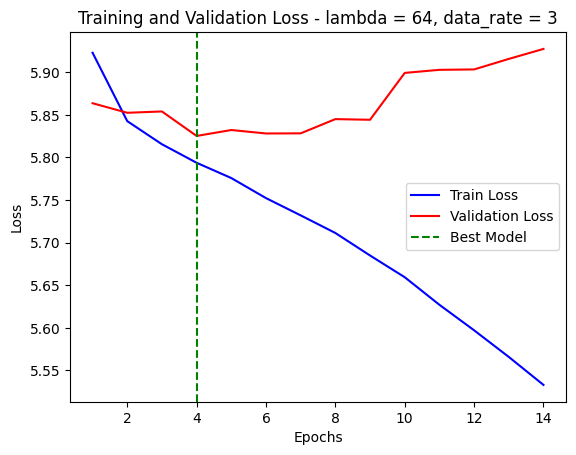

/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warn

Epoch 1 train loss : 5.679364716003486


Epoch 1/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.10it/s, valid_loss=5.61]


Epoch 1 valid loss : 5.606898282748924
Found better model. Best loss: 5.606898282748924
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=6.pth


Epoch 2/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.42it/s, train_loss=5.51]


Epoch 2 train loss : 5.510738647390077


Epoch 2/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 41.75it/s, valid_loss=5.49]


Epoch 2 valid loss : 5.489109459230219
Found better model. Best loss: 5.489109459230219
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=6.pth


Epoch 3/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.53it/s, train_loss=5.45]


Epoch 3 train loss : 5.4467463755050645


Epoch 3/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.47it/s, valid_loss=5.52]


Epoch 3 valid loss : 5.517378452825851


Epoch 4/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.71it/s, train_loss=5.4]


Epoch 4 train loss : 5.397969501574812


Epoch 4/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.75it/s, valid_loss=5.5]


Epoch 4 valid loss : 5.502729792916663


Epoch 5/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.79it/s, train_loss=5.35]


Epoch 5 train loss : 5.345247962660699


Epoch 5/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.70it/s, valid_loss=5.47]


Epoch 5 valid loss : 5.472710572093837
Found better model. Best loss: 5.472710572093837
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=6.pth


Epoch 6/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 29.72it/s, train_loss=5.29]


Epoch 6 train loss : 5.289848119481798


Epoch 6/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 40.25it/s, valid_loss=5.47]


Epoch 6 valid loss : 5.471573057912132
Found better model. Best loss: 5.471573057912132
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=6.pth


Epoch 7/30 - Training: 100%|██████████| 889/889 [00:30<00:00, 29.33it/s, train_loss=5.23]


Epoch 7 train loss : 5.234928782007039


Epoch 7/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.16it/s, valid_loss=5.49]


Epoch 7 valid loss : 5.490097821708032


Epoch 8/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.96it/s, train_loss=5.17]


Epoch 8 train loss : 5.174347773357877


Epoch 8/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.04it/s, valid_loss=5.49]


Epoch 8 valid loss : 5.487107551855282


Epoch 9/30 - Training: 100%|██████████| 889/889 [00:31<00:00, 28.66it/s, train_loss=5.12]


Epoch 9 train loss : 5.120623997222059


Epoch 9/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 41.35it/s, valid_loss=5.53]


Epoch 9 valid loss : 5.52523072978151


Epoch 10/30 - Training: 100%|██████████| 889/889 [00:32<00:00, 27.41it/s, train_loss=5.07]


Epoch 10 train loss : 5.071313963518859


Epoch 10/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 40.30it/s, valid_loss=5.5]


Epoch 10 valid loss : 5.496912606379763


Epoch 11/30 - Training: 100%|██████████| 889/889 [00:30<00:00, 29.00it/s, train_loss=5.02]


Epoch 11 train loss : 5.023157891977548


Epoch 11/30 - Validation: 100%|██████████| 191/191 [00:05<00:00, 33.78it/s, valid_loss=5.51]


Epoch 11 valid loss : 5.511077111938907


Epoch 12/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.36it/s, train_loss=4.98]


Epoch 12 train loss : 4.981056919038849


Epoch 12/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.02it/s, valid_loss=5.53]


Epoch 12 valid loss : 5.531119458332102


Epoch 13/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.38it/s, train_loss=4.94]


Epoch 13 train loss : 4.944092514881979


Epoch 13/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.86it/s, valid_loss=5.55]


Epoch 13 valid loss : 5.5499930491374645


Epoch 14/30 - Training: 100%|██████████| 889/889 [00:30<00:00, 29.45it/s, train_loss=4.9]


Epoch 14 train loss : 4.899684021716516


Epoch 14/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.09it/s, valid_loss=5.5]


Epoch 14 valid loss : 5.4976544871038255


Epoch 15/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 29.80it/s, train_loss=4.87]


Epoch 15 train loss : 4.872129396824578


Epoch 15/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 39.89it/s, valid_loss=5.56]


Epoch 15 valid loss : 5.564428513517052


Epoch 16/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.60it/s, train_loss=4.84]


Epoch 16 train loss : 4.844826615094937


Epoch 16/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.33it/s, valid_loss=5.53]


Epoch 16 valid loss : 5.53138623404358
Early stopping at epoch 16


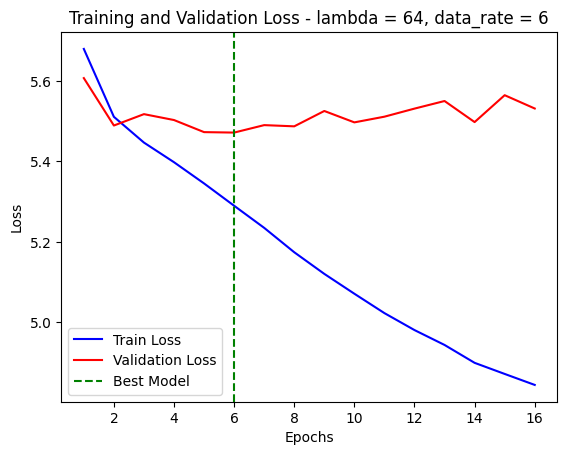

/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warn

Epoch 1 train loss : 5.639249036924758


Epoch 1/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 38.64it/s, valid_loss=5.48]


Epoch 1 valid loss : 5.478189979744865
Found better model. Best loss: 5.478189979744865
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=9.pth


Epoch 2/30 - Training: 100%|██████████| 889/889 [00:30<00:00, 29.11it/s, train_loss=5.41]


Epoch 2 train loss : 5.412699929432502


Epoch 2/30 - Validation: 100%|██████████| 191/191 [00:05<00:00, 38.19it/s, valid_loss=5.39]


Epoch 2 valid loss : 5.387200192382743
Found better model. Best loss: 5.387200192382743
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=9.pth


Epoch 3/30 - Training: 100%|██████████| 889/889 [00:30<00:00, 29.29it/s, train_loss=5.33]


Epoch 3 train loss : 5.327700711289762


Epoch 3/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 39.73it/s, valid_loss=5.37]


Epoch 3 valid loss : 5.371210501985075
Found better model. Best loss: 5.371210501985075
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=9.pth


Epoch 4/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 29.86it/s, train_loss=5.26]


Epoch 4 train loss : 5.264113025735071


Epoch 4/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 40.11it/s, valid_loss=5.34]


Epoch 4 valid loss : 5.337347775839601
Found better model. Best loss: 5.337347775839601
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=9.pth


Epoch 5/30 - Training: 100%|██████████| 889/889 [00:32<00:00, 27.35it/s, train_loss=5.21]


Epoch 5 train loss : 5.206181048407475


Epoch 5/30 - Validation: 100%|██████████| 191/191 [00:05<00:00, 38.09it/s, valid_loss=5.34]


Epoch 5 valid loss : 5.340554045096463


Epoch 6/30 - Training: 100%|██████████| 889/889 [00:32<00:00, 27.75it/s, train_loss=5.15]


Epoch 6 train loss : 5.146999355238859


Epoch 6/30 - Validation: 100%|██████████| 191/191 [00:05<00:00, 33.70it/s, valid_loss=5.39]


Epoch 6 valid loss : 5.385698780757495


Epoch 7/30 - Training: 100%|██████████| 889/889 [00:31<00:00, 28.30it/s, train_loss=5.08]


Epoch 7 train loss : 5.0840091793898825


Epoch 7/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 40.08it/s, valid_loss=5.37]


Epoch 7 valid loss : 5.374989717352314


Epoch 8/30 - Training: 100%|██████████| 889/889 [00:30<00:00, 29.59it/s, train_loss=5.02]


Epoch 8 train loss : 5.016943150226949


Epoch 8/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 40.23it/s, valid_loss=5.39]


Epoch 8 valid loss : 5.3919067902628415


Epoch 9/30 - Training: 100%|██████████| 889/889 [00:30<00:00, 29.05it/s, train_loss=4.95]


Epoch 9 train loss : 4.954637050897076


Epoch 9/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 39.99it/s, valid_loss=5.43]


Epoch 9 valid loss : 5.431112887843296


Epoch 10/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.01it/s, train_loss=4.9]


Epoch 10 train loss : 4.900113060680403


Epoch 10/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 41.27it/s, valid_loss=5.39]


Epoch 10 valid loss : 5.388749090992275


Epoch 11/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 29.92it/s, train_loss=4.85]


Epoch 11 train loss : 4.852390530342254


Epoch 11/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 41.64it/s, valid_loss=5.39]


Epoch 11 valid loss : 5.394390918961536


Epoch 12/30 - Training: 100%|██████████| 889/889 [00:30<00:00, 28.75it/s, train_loss=4.81]


Epoch 12 train loss : 4.811417797066076


Epoch 12/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 40.66it/s, valid_loss=5.37]


Epoch 12 valid loss : 5.369952770196203


Epoch 13/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.10it/s, train_loss=4.77]


Epoch 13 train loss : 4.766805683160681


Epoch 13/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.60it/s, valid_loss=5.38]


Epoch 13 valid loss : 5.381098103589797


Epoch 14/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.54it/s, train_loss=4.73]


Epoch 14 train loss : 4.734062372111549


Epoch 14/30 - Validation: 100%|██████████| 191/191 [00:05<00:00, 34.88it/s, valid_loss=5.41]


Epoch 14 valid loss : 5.407324111984195
Early stopping at epoch 14


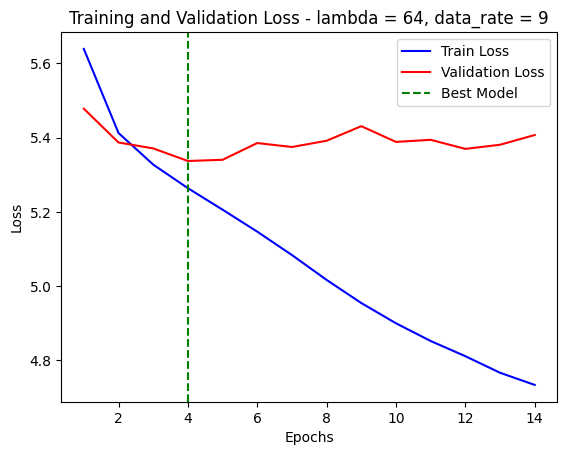

/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warn

Epoch 1 train loss : 5.5857230710406185


Epoch 1/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 38.83it/s, valid_loss=5.43]


Epoch 1 valid loss : 5.429261040440962
Found better model. Best loss: 5.429261040440962
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=12.pth


Epoch 2/30 - Training: 100%|██████████| 889/889 [00:30<00:00, 29.02it/s, train_loss=5.39]


Epoch 2 train loss : 5.3874446029834875


Epoch 2/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 39.25it/s, valid_loss=5.37]


Epoch 2 valid loss : 5.3725716440259985
Found better model. Best loss: 5.3725716440259985
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=12.pth


Epoch 3/30 - Training: 100%|██████████| 889/889 [00:31<00:00, 28.48it/s, train_loss=5.32]


Epoch 3 train loss : 5.32176313177485


Epoch 3/30 - Validation: 100%|██████████| 191/191 [00:05<00:00, 37.22it/s, valid_loss=5.36]


Epoch 3 valid loss : 5.362388595026167
Found better model. Best loss: 5.362388595026167
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=12.pth


Epoch 4/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.17it/s, train_loss=5.27]


Epoch 4 train loss : 5.268586533994967


Epoch 4/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 38.80it/s, valid_loss=5.34]


Epoch 4 valid loss : 5.335155561588371
Found better model. Best loss: 5.335155561588371
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=12.pth


Epoch 5/30 - Training: 100%|██████████| 889/889 [00:30<00:00, 29.01it/s, train_loss=5.22]


Epoch 5 train loss : 5.220000497864697


Epoch 5/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 38.66it/s, valid_loss=5.34]


Epoch 5 valid loss : 5.3422019331742145


Epoch 6/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 29.79it/s, train_loss=5.16]


Epoch 6 train loss : 5.1632821787386725


Epoch 6/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.97it/s, valid_loss=5.34]


Epoch 6 valid loss : 5.336953317995749


Epoch 7/30 - Training: 100%|██████████| 889/889 [00:30<00:00, 29.39it/s, train_loss=5.11]


Epoch 7 train loss : 5.1118311453899


Epoch 7/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 38.66it/s, valid_loss=5.37]


Epoch 7 valid loss : 5.366064438657834


Epoch 8/30 - Training: 100%|██████████| 889/889 [00:30<00:00, 28.71it/s, train_loss=5.03]


Epoch 8 train loss : 5.033188901483056


Epoch 8/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 40.34it/s, valid_loss=5.33]


Epoch 8 valid loss : 5.327924782645426
Found better model. Best loss: 5.327924782645426
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=12.pth


Epoch 9/30 - Training: 100%|██████████| 889/889 [00:30<00:00, 29.38it/s, train_loss=4.97]


Epoch 9 train loss : 4.965126951278313


Epoch 9/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 40.11it/s, valid_loss=5.34]


Epoch 9 valid loss : 5.34076520230574


Epoch 10/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.46it/s, train_loss=4.91]


Epoch 10 train loss : 4.9075914570019


Epoch 10/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.83it/s, valid_loss=5.34]


Epoch 10 valid loss : 5.335614582056131


Epoch 11/30 - Training: 100%|██████████| 889/889 [00:31<00:00, 28.17it/s, train_loss=4.86]


Epoch 11 train loss : 4.86317316780552


Epoch 11/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 39.76it/s, valid_loss=5.35]


Epoch 11 valid loss : 5.3504610579895715


Epoch 12/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 29.89it/s, train_loss=4.82]


Epoch 12 train loss : 4.817484458802017


Epoch 12/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.15it/s, valid_loss=5.33]


Epoch 12 valid loss : 5.331321076324393


Epoch 13/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.74it/s, train_loss=4.78]


Epoch 13 train loss : 4.77986217692574


Epoch 13/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.09it/s, valid_loss=5.35]


Epoch 13 valid loss : 5.346355528260781


Epoch 14/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.86it/s, train_loss=4.74]


Epoch 14 train loss : 4.740897794122801


Epoch 14/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.96it/s, valid_loss=5.39]


Epoch 14 valid loss : 5.388458231285745


Epoch 15/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.44it/s, train_loss=4.71]


Epoch 15 train loss : 4.711626149485422


Epoch 15/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 39.33it/s, valid_loss=5.34]


Epoch 15 valid loss : 5.343070539694626


Epoch 16/30 - Training: 100%|██████████| 889/889 [00:30<00:00, 29.59it/s, train_loss=4.68]


Epoch 16 train loss : 4.681378619287707


Epoch 16/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.03it/s, valid_loss=5.34]


Epoch 16 valid loss : 5.344412602064665


Epoch 17/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.75it/s, train_loss=4.66]


Epoch 17 train loss : 4.655437711591691


Epoch 17/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.46it/s, valid_loss=5.34]


Epoch 17 valid loss : 5.339147509113162


Epoch 18/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.88it/s, train_loss=4.63]


Epoch 18 train loss : 4.632297403940576


Epoch 18/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.37it/s, valid_loss=5.36]


Epoch 18 valid loss : 5.356052731786567
Early stopping at epoch 18


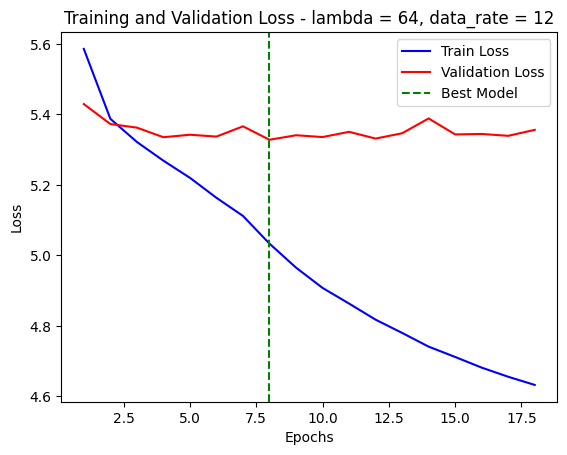

In [6]:
import matplotlib.pyplot as plt

lambda_value = 64
data_rates = [1, 3, 6, 9, 12]
ROOT = '/media/global_data/fair_neural_compression_data/decoded_rfw'
RATIO = 0.7
num_epochs = 30
patience = 10
lr = 0.01

for data_rate in data_rates:
    compressed_image_path = f'{ROOT}/progressive_64x64/qres17m/q_{lambda_value}/{data_rate}'
    RFW_LABELS_DIR = "/media/global_data/fair_neural_compression_data/datasets/RFW/clean_metadata/numerical_labels.csv"
    train_loader, valid_loader, test_loader = create_dataloaders(
        compressed_image_path, 
        RFW_LABELS_DIR, 
        BATCH_SIZE, 
        RATIO
    )
    
    output_dims = {
        'skin_type': 6,
        'eye_type': 2,
        'nose_type': 2,
        'lip_type': 2,
        'hair_type': 4,
        'hair_color': 5
    }
    model = MultiHeadResNet(output_dims).to(device)
    
    trained_model, train_losses, valid_losses = train_numerical_rfw(
        model, 
        torch.optim.SGD,
        num_epochs, 
        lr, 
        train_loader, 
        valid_loader,
        device,
        '../../models/converged_models',
        f'RFW_resnet18_lambda={lambda_value}_data_rate={data_rate}',
        patience=patience
    )
    
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'b', label='Train Loss')
    plt.plot(epochs, valid_losses, 'r', label='Validation Loss')
    plt.title(f'Training and Validation Loss - lambda = {lambda_value}, data_rate = {data_rate}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    best_epoch = valid_losses.index(min(valid_losses)) + 1

    # Add a vertical line at the epoch with the lowest validation loss
    plt.axvline(x=best_epoch, color='g', linestyle='--', label='Best Model')

    plt.legend()
    plt.savefig(f'/home/rasta/fair-neural-compression-eval/models/converged_models/plots/RFW_resnet18_lambda={lambda_value}_data_rate={data_rate}.png')
    plt.show()

In [28]:
output_dims = {
    'skin_type': 6,
    'eye_type': 2,
    'nose_type': 2,
    'lip_type': 2,
    'hair_type': 4,
    'hair_color': 5
}
model = MultiHeadResNet(output_dims).to(device)
num_epochs = 30
patience = 10
lr = 0.01

trained_model, train_losses, valid_losses = train_numerical_rfw(
    model, 
    torch.optim.SGD,
    num_epochs, 
    lr, 
    train_loader, 
    valid_loader,
    device,
    '../../models/converged_models',
    f'RFW_resnet18_lambda={lambda_value}_data_rate={data_rate}',
    patience=patience
)

/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/30 - Training: 100%|██████████| 1016/1016 [00:32<00:00, 30.95it/s, train_loss=5.92]


Epoch 1 train loss : 5.921808594440486


Epoch 1/30 - Validation: 100%|██████████| 127/127 [00:02<00:00, 42.59it/s, valid_loss=6.43]


Epoch 1 valid loss : 6.4342236837436415
Found better model. Best loss: 6.4342236837436415
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=1.pth


Epoch 2/30 - Training: 100%|██████████| 1016/1016 [00:33<00:00, 30.45it/s, train_loss=5.87]


Epoch 2 train loss : 5.874472895383431


Epoch 2/30 - Validation: 100%|██████████| 127/127 [00:02<00:00, 43.07it/s, valid_loss=6.41]


Epoch 2 valid loss : 6.407854860712742
Found better model. Best loss: 6.407854860712742
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=1.pth


Epoch 3/30 - Training: 100%|██████████| 1016/1016 [00:33<00:00, 30.62it/s, train_loss=5.86]


Epoch 3 train loss : 5.856426678552285


Epoch 3/30 - Validation: 100%|██████████| 127/127 [00:02<00:00, 43.15it/s, valid_loss=6.45]


Epoch 3 valid loss : 6.4490802067107165


Epoch 4/30 - Training: 100%|██████████| 1016/1016 [00:33<00:00, 30.73it/s, train_loss=5.84]


Epoch 4 train loss : 5.842967773470967


Epoch 4/30 - Validation: 100%|██████████| 127/127 [00:02<00:00, 42.81it/s, valid_loss=6.4]


Epoch 4 valid loss : 6.401553137934413
Found better model. Best loss: 6.401553137934413
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=1.pth


Epoch 5/30 - Training: 100%|██████████| 1016/1016 [00:32<00:00, 30.82it/s, train_loss=5.83]


Epoch 5 train loss : 5.82859058547464


Epoch 5/30 - Validation: 100%|██████████| 127/127 [00:02<00:00, 42.85it/s, valid_loss=6.45]


Epoch 5 valid loss : 6.445312618181624


Epoch 6/30 - Training: 100%|██████████| 1016/1016 [00:32<00:00, 30.88it/s, train_loss=5.82]


Epoch 6 train loss : 5.815159849146614


Epoch 6/30 - Validation: 100%|██████████| 127/127 [00:02<00:00, 43.11it/s, valid_loss=6.43]


Epoch 6 valid loss : 6.4315942918946005


Epoch 7/30 - Training: 100%|██████████| 1016/1016 [00:33<00:00, 30.76it/s, train_loss=5.8]


Epoch 7 train loss : 5.799856560293007


Epoch 7/30 - Validation: 100%|██████████| 127/127 [00:02<00:00, 43.01it/s, valid_loss=6.44]


Epoch 7 valid loss : 6.436768308410357


Epoch 8/30 - Training: 100%|██████████| 1016/1016 [00:32<00:00, 30.90it/s, train_loss=5.78]


Epoch 8 train loss : 5.783577169013497


Epoch 8/30 - Validation: 100%|██████████| 127/127 [00:02<00:00, 42.70it/s, valid_loss=6.45]


Epoch 8 valid loss : 6.452071777962405


Epoch 9/30 - Training: 100%|██████████| 1016/1016 [00:33<00:00, 30.78it/s, train_loss=5.77]


Epoch 9 train loss : 5.767174193491032


Epoch 9/30 - Validation: 100%|██████████| 127/127 [00:02<00:00, 43.39it/s, valid_loss=6.47]


Epoch 9 valid loss : 6.465258012044019


Epoch 10/30 - Training: 100%|██████████| 1016/1016 [00:33<00:00, 30.45it/s, train_loss=5.75]


Epoch 10 train loss : 5.748688192633238


Epoch 10/30 - Validation: 100%|██████████| 127/127 [00:02<00:00, 43.60it/s, valid_loss=6.44]


Epoch 10 valid loss : 6.442232610079749


Epoch 11/30 - Training: 100%|██████████| 1016/1016 [00:33<00:00, 30.78it/s, train_loss=5.73]


Epoch 11 train loss : 5.728069653451598


Epoch 11/30 - Validation: 100%|██████████| 127/127 [00:02<00:00, 43.25it/s, valid_loss=6.49]


Epoch 11 valid loss : 6.492771086893205


Epoch 12/30 - Training: 100%|██████████| 1016/1016 [00:32<00:00, 31.12it/s, train_loss=5.71]


Epoch 12 train loss : 5.710449144872166


Epoch 12/30 - Validation: 100%|██████████| 127/127 [00:02<00:00, 42.95it/s, valid_loss=6.52]


Epoch 12 valid loss : 6.519677780183224


Epoch 13/30 - Training: 100%|██████████| 1016/1016 [00:32<00:00, 30.86it/s, train_loss=5.69]


Epoch 13 train loss : 5.688142980963373


Epoch 13/30 - Validation: 100%|██████████| 127/127 [00:02<00:00, 43.47it/s, valid_loss=6.46]


Epoch 13 valid loss : 6.4631482897133665


Epoch 14/30 - Training: 100%|██████████| 1016/1016 [00:33<00:00, 30.75it/s, train_loss=5.67]


Epoch 14 train loss : 5.666318143527838


Epoch 14/30 - Validation: 100%|██████████| 127/127 [00:02<00:00, 42.65it/s, valid_loss=6.49]

Epoch 14 valid loss : 6.493416118724593
Early stopping at epoch 14


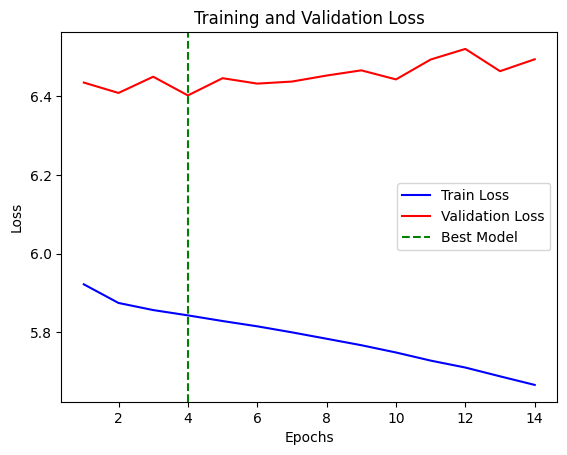

In [29]:
import matplotlib.pyplot as plt

# Sample lists of train and validation losses
# train_losses = [0.5, 0.4, 0.3, 0.2, 0.1]
# val_losses = [0.6, 0.5, 0.4, 0.3, 0.2]

# Plotting
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, 'b', label='Train Loss')
plt.plot(epochs, valid_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

best_epoch = valid_losses.index(min(valid_losses)) + 1

# Add a vertical line at the epoch with the lowest validation loss
plt.axvline(x=best_epoch, color='g', linestyle='--', label='Best Model')

plt.legend()
plt.show()